## Prerequisites

In [1]:
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers, _butter_lowpass
import os, re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

In [2]:
# Set data directory
PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"

In the parent folder, the data are organized as follows:

```
PARENT_FOLDER
└───pp001
│   └───imu
│       │   imu_backwards.mat
│       │   imu_balance_sbs.mat
│       │   ...
│   └───optical
│       │   omc_backwards.mat
│       │   omc_balance_sbs.mat
│       │   ...
└───pp002
│   └───imu
│       │   imu_backwards.mat
│       │   imu_balance_sbs.mat
│       │   ...
│   └───optical
│       │   omc_backwards.mat
│       │   omc_balance_sbs.mat
│       │   ...
└───...
```

In [3]:
# Get a list of folders, each folder corresponds to a participant id
participant_ids = [pid for pid in os.listdir(PARENT_FOLDER) if pid.startswith("pp")]

In [4]:
# Set trials of interest
trial_name = "walk_preferred"

# For each participant id
for pid in participant_ids[:1]:

    # Get a list of IMU data files
    imu_files = [fname for fname in os.listdir(os.path.join(PARENT_FOLDER, pid, "imu")) if fname.endswith(".mat")]

    # For each file
    for imu_filename in imu_files:

        if trial_name in imu_filename:
                
            # Check if there is a valid `omc` data file available
            if os.path.isfile(os.path.join(PARENT_FOLDER, pid, "optical", imu_filename.replace("imu_", "omc_"))):
                omc_filename = imu_filename.replace("imu_", "omc_")
                print(f"IMU data: {imu_filename:s}")
                print(f"OMC data: {omc_filename:s}")

                # Load marker data
                marker_data = _load_file(os.path.join(PARENT_FOLDER, pid, "optical", omc_filename))

IMU data: imu_walk_preferred.mat
OMC data: omc_walk_preferred.mat


## Process marker data
First, missing marker data are reconstructed by calling the corresponding function (Federolf, 2013; Gløersen and Federolf, 2016), and then the marker data are low-pass filtered (in forward and backward direction to prevent delay ()).

In [6]:
aux_markers = ["start_1", "start_2", "end_1", "end_2"]  # set auxiliary markers (i.e., markers not on the body)
ix_aux_markers = [ix for ix in range(len(marker_data["marker_location"])) if marker_data["marker_location"][ix] not in aux_markers]

The marker data need to be reshaped, before we can call `predict_missing_markers()` on it.

In [7]:
M = np.reshape(marker_data["pos"][:,:3,:], (marker_data["pos"].shape[0], 3*marker_data["pos"].shape[-1]), order="F")
M = _predict_missing_markers(M)
pos = np.reshape(M, (M.shape[0], 3, marker_data["pos"].shape[-1]), order="F")

In [34]:
def get_marker_trajectory(pos, label, marker_labels):
    """Returns the 3D marker position data for a given marker.

    Parameters
    ----------
    pos : (N, 3, M) array_like
        The 3D marker position data, with N time steps, 3 dimensions, and M markers.
    label : str, optional
        The marker for which you inquire the position data.
    marker_labels : array_like
        A list or array-like with the names of the marker labels.
    """

    # Get index of current marker in data array
    ix = np.argwhere(marker_labels==label)[:,0]
    return np.squeeze(pos[:,:,ix], axis=-1)

In [35]:
# Get the position of the start and end markers
start_1 = get_marker_trajectory(pos, "start_1", marker_data["marker_location"])
start_2 = get_marker_trajectory(pos, "start_2", marker_data["marker_location"])
end_1 = get_marker_trajectory(pos, "end_1", marker_data["marker_location"])
end_2 = get_marker_trajectory(pos, "end_2", marker_data["marker_location"])
start_1 = np.nanmean(start_1, axis=0)
start_2 = np.nanmean(start_2, axis=0)
end_1 = np.nanmean(end_1, axis=0)
end_2 = np.nanmean(end_2, axis=0)

# Get position data from the iliac spine markers
l_psis = get_marker_trajectory(pos, "l_psis", marker_data["marker_location"])
r_psis = get_marker_trajectory(pos, "r_psis", marker_data["marker_location"])
l_asis = get_marker_trajectory(pos, "l_asis", marker_data["marker_location"])
r_asis = get_marker_trajectory(pos, "r_asis", marker_data["marker_location"])

# Calculate a virtual COM trajectory
mid_psis = ( l_psis + r_psis ) / 2
mid_asis = ( l_asis + r_asis ) / 2

In [99]:
# Low-pass filter the data
pos_filt = _butter_lowpass(pos, marker_data["fs"])

# Get filtered position data
l_psis_filt = get_marker_trajectory(pos_filt, "l_psis", marker_data["marker_location"])
r_psis_filt = get_marker_trajectory(pos_filt, "r_psis", marker_data["marker_location"])
l_asis_filt = get_marker_trajectory(pos_filt, "l_asis", marker_data["marker_location"])
r_asis_filt = get_marker_trajectory(pos_filt, "r_asis", marker_data["marker_location"])
l_heel_filt = get_marker_trajectory(pos_filt, "l_heel", marker_data["marker_location"])
r_heel_filt = get_marker_trajectory(pos_filt, "r_heel", marker_data["marker_location"])
l_toe_filt = get_marker_trajectory(pos_filt, "l_toe", marker_data["marker_location"])
r_toe_filt = get_marker_trajectory(pos_filt, "r_toe", marker_data["marker_location"])

# Mid
mid_psis_filt = ( l_psis_filt + r_psis_filt ) / 2
mid_asis_filt = ( l_asis_filt + r_asis_filt ) / 2

In [100]:
# Calculate virtual pelvis trajectory
pelvis = ( mid_psis_filt + mid_asis_filt ) / 2

# Calculate moving antero-posterior axis as tangent to pelvis trajectory
x_ap = pelvis[1:,:] - pelvis[:-1,:]

# Normalize to unit length
x_ap = np.divide(x_ap, np.linalg.norm(x_ap, axis=-1).reshape(-1,1))

# Define vertical axis upwards 
z_vt = np.ones_like(x_ap)
z_vt[:,:2] = 0

# Calculate the corresponding medio-lateral axis
y_ml = np.cross(z_vt, x_ap)

# Normalize to unit length
y_ml = np.divide(y_ml, np.linalg.norm(y_ml, axis=-1).reshape(-1,1))

# Update antero-posterior axis -- gets rid of any global Z-component
x_ap = np.cross(y_ml, z_vt)

The marker position data are originally expressed in a laboratory-fixed coordinate frame, denoted by the pre-superscript $\left\{^{\mathcal{N}}\hat{\mathbf{X}}, ^{\mathcal{N}}\hat{\mathbf{Y}}, ^{\mathcal{N}}\hat{\mathbf{Z}} \right\}$  
The data are therefore first transform to an anatomical reference frame, obtained from the iliac spine markers, and denoted by: $\left\{^{\mathcal{B}}\hat{\mathbf{x}}_{t}, ^{\mathcal{B}}\hat{\mathbf{y}}_{t}, ^{\mathcal{B}}\hat{\mathbf{z}}_{t} \right\}$ with the subscript $_{t}$ denoting the time dependency (it is changing over time, as the subject moves forward).  

Using the virtual pelvis marker trajectory, we have expressed the body-fixed coordinate system in terms of the global axes: $\left\{^{\mathcal{N}}\hat{\mathbf{x}}_{t}, ^{\mathcal{N}}\hat{\mathbf{y}}_{t}, ^{\mathcal{N}}\hat{\mathbf{z}}_{t} \right\}$:

$$^{\mathcal{N}}\mathbf{x}_{\mathrm{AP}}(t) = 0.95 ^{\mathcal{N}}\hat{\mathbf{I}} - 0.32 ^{\mathcal{N}}\hat{\mathbf{J}} + 0 ^{\mathcal{N}}\hat{\mathbf{K}}$$

In [101]:
# Construct the rotation matrix, for each time step
R = np.reshape(np.vstack((x_ap.T, y_ml.T, z_vt.T)), (3, 3, len(x_ap)), order="F")
print(R.shape)

(3, 3, 1788)


In [102]:
S = np.empty_like(R)
for ti in range(R.shape[-1]):
    S[:,:,ti] = np.dot(R[:,:,ti].T, np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]))

In [106]:
T = np.empty((3, 3, pelvis.shape[0]))
T[:,:,0] = S[:,:,0]
T[:,:,1:] = S

In [107]:
# Get relative position of right heel marker to virtual pelvis marker
# as expressed in the global frame
d = r_heel_filt - pelvis
print(d.shape)

(1789, 3)


In [112]:
s = np.empty_like(d)
for ti in range(d.shape[0]):
    v = T[:,:,ti] @ d[ti,:].T
    s[ti,:]

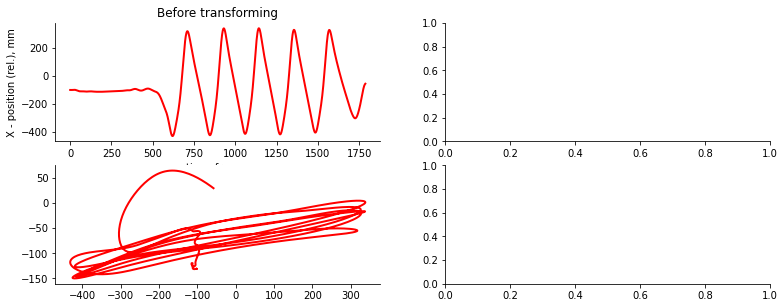

In [116]:
fig, ax = plt.subplots(2, 2, figsize=(12.8, 4.8))
ax[0][0].plot(np.arange(d.shape[0]), d[:,0], '-', c='r', lw=2)
ax[0][0].set_xlabel("time, frames")
ax[0][0].set_ylabel("X - position (rel.), mm")
ax[0][0].set_title("Before transforming")
ax[1][0].plot(d[:,0], d[:,1], '-', c='r', lw=2)
plt.show()

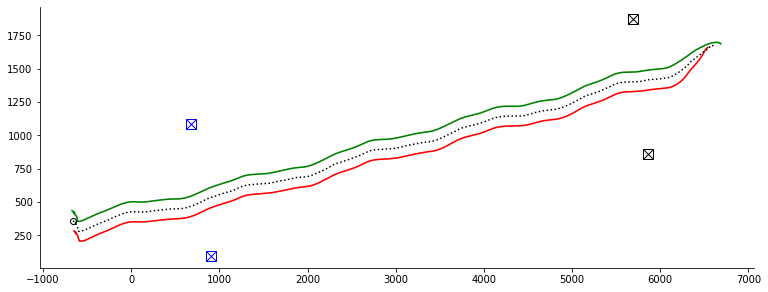

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(19.2, 4.8))

# Plot start and end markers
ax[0].plot(start_1[0], start_1[1], 'x', c=(0, 0, 1), ms=10)
ax[0].plot(start_1[0], start_1[1], 's', mfc="none", mec=(0, 0, 1), ms=10)
ax[0].plot(start_2[0], start_2[1], 'x', c=(0, 0, 1), ms=10)
ax[0].plot(start_2[0], start_2[1], 's', mfc="none", mec=(0, 0, 1), ms=10)
ax[0].plot(end_1[0], end_1[1], 'x', c=(0, 0, 0), ms=10)
ax[0].plot(end_1[0], end_1[1], 's', mfc="none", mec=(0, 0, 0), ms=10)
ax[0].plot(end_2[0], end_2[1], 'x', c=(0, 0, 0), ms=10)
ax[0].plot(end_2[0], end_2[1], 's', mfc="none", mec=(0, 0, 0), ms=10)

# Plot iliac spine marker trajectories
ax[0].plot(l_psis[:,0], l_psis[:,1], c=(0, .5, 0, 0.3))
ax[0].plot(l_psis_filt[:,0], l_psis_filt[:,1], c=(0, .5, 0))
ax[0].plot(r_psis[:,0], r_psis[:,1], c=(1, 0, 0, 0.3))
ax[0].plot(r_psis_filt[:,0], r_psis_filt[:,1], c=(1, 0, 0))
ax[0].plot(mid_psis[:,0], mid_psis[:,1], c=(0, 0, 0), ls=':')
ax[0].plot(mid_psis[0,0], mid_psis[0,1], 'o', mfc='None', mec='k')


plt.show()

In [52]:
import plotly.graph_objects as go

# Set list of marker names to plot
markers2plot = ["l_asis", "l_psis", "r_asis", "r_psis"]
colors2plot = ["rgba(0, 0.5, 0)", "rgba(0, 1.0, 0)", "rgba(0.8, 0, 0)", "rgba(1.0, 0, 0)"]

# Instantiate a plotly Figure object
fig = go.Figure()
cnt = 0
for mrk in markers2plot:
    ix = np.argwhere(marker_data["marker_location"]==mrk)[:,0]
    xs = marker_data["pos"][:,0,ix].reshape(-1,)
    ys = marker_data["pos"][:,1,ix].reshape(-1,)
    zs = marker_data["pos"][:,2,ix].reshape(-1,)

    fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zs, mode="lines", line=dict(color=colors2plot[cnt]), name=mrk))
    cnt += 1

fig.update_layout(width=1200, height=600, scene=dict(aspectratio=dict(x=1, y=0.5, z=0.6)))
fig.show()

In [37]:
xs = marker_data["pos"][:,0,ix_label]
ys = marker_data["pos"][:,1,ix_label]
zs = marker_data["pos"][:,2,ix_label]
print(f"Shape of xs: {xs.shape}\nShape of ys: {ys.shape}\nShape of zs: {zs.shape}")

xs = xs.reshape(-1,)
ys = ys.reshape(-1,)
zs = zs.reshape(-1,)
print(f"Shape of xs: {xs.shape}\nShape of ys: {ys.shape}\nShape of zs: {zs.shape}")

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zs, marker=dict(size=1), line=dict(width=1)))
fig.show()

Shape of xs: (1789, 1)
Shape of ys: (1789, 1)
Shape of zs: (1789, 1)
Shape of xs: (1789,)
Shape of ys: (1789,)
Shape of zs: (1789,)


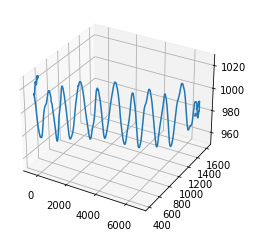

In [26]:
# Generate data
xs = marker_data["pos"][:,0,ix_label][:,0]
ys = marker_data["pos"][:,1,ix_label][:,0]
zs = marker_data["pos"][:,2,ix_label][:,0]

# Instantiate figure object
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  # add axes object to figure
ax.plot(xs, ys, zs)
plt.show()

## Load data
Let us load the data from the inertial measurement units from the 5 meter walk trial, at preferred walking speed.

In [10]:
# Set the filename
my_filename = "imu_walk_preferred.mat"

# Call
data = _load_file(os.path.join(PARENT_FOLDER, pid, "imu", my_filename))

In [12]:
print(data.keys())

dict_keys(['calibration_file', 'acc', 'gyro', 'magn', 'fs', 'imu_location'])


In [29]:
print(data["imu_location"])

['head' 'sternum' 'left_upper_arm' 'left_fore_arm' 'right_upper_arm'
 'right_fore_arm' 'pelvis' 'left_thigh' 'left_shank' 'left_foot'
 'right_thigh' 'right_shank' 'right_foot' 'left_ankle' 'right_ankle'
 'pocket']


## Plot data
Let us plot some data, for example the gyroscope data from the left and right ankle sensor.

In [28]:
# Set sensor name
my_sensors = ["left_ankle", "right_ankle"]

# Get the corresponding indexes
ixs = [np.argwhere(data["imu_location"]==s)[:,0][0] for s in my_sensors]
print(ixs)

[13, 14]


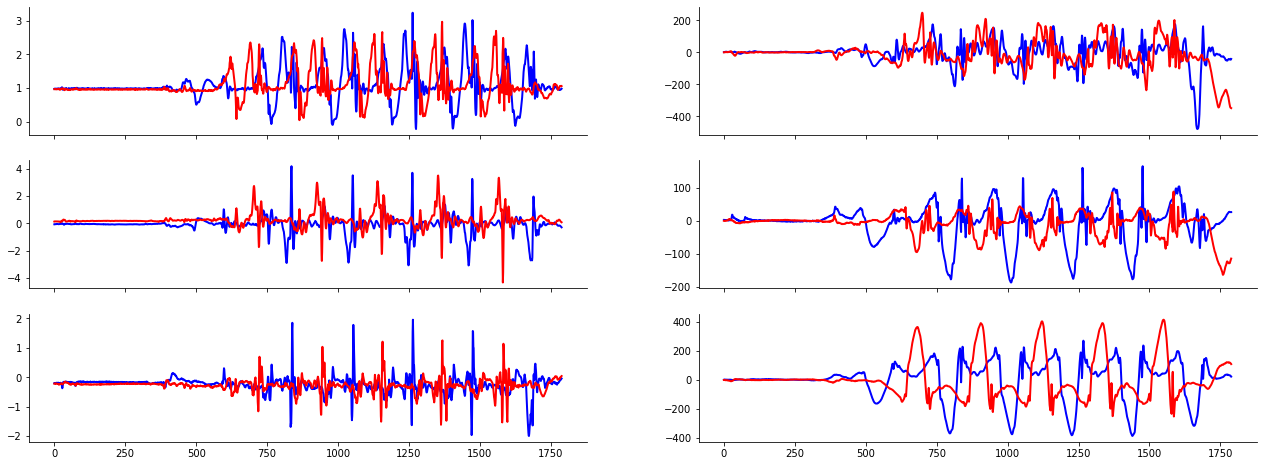

In [43]:
# Create figure
fig, axs = plt.subplots(3, 2, figsize=(22, 8), sharex=True)
for ix in ixs:
    if "left_" in data["imu_location"][ix]:
        clr = "b"
    else:
        clr = "r"

    # Plot accelerometer data
    acc = data["acc"][:,:,ix]
    for idim in range(acc.shape[1]):
        axs[idim,0].plot(acc[:,idim], '-', c=clr, lw=2)

    # Plot gyroscope data
    gyro = data["gyro"][:,:,ix]
    for idim in range(gyro.shape[1]):
        axs[idim,1].plot(gyro[:,idim], '-', c=clr, lw=2)
